In [1]:
%%capture
import numpy as np
from mitiq import zne
import h5py
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile
import qiskit.providers.aer.noise as noise
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

# import circuit needed

In [2]:
# simplified pauli measurement label and coefficient
simplified_h_diag_measure_list = [1, 11]
simplified_h_offdiag_measure_list = [0, 1, 3, 5, 11]
h_diag_coefficient_list = [-0.1779291653897952, 0.36978265527106347, -0.6365898571875489]
h_off_coefficient_list = [-0.6365898561329018, -0.17792916538979606, 0.153506530287386, 0.1535065227735808, 0.36978266455828424]

# import circuits used for estimating the overlap and hamiltonian matrix

# circuit for s offdiagonal 
qc_s_offdiagonal_qasm =  QuantumCircuit().from_qasm_str(open('qc_transpiled.qasm', 'r').read())
qc_s_offdiagonal = transpile(qc_s_offdiagonal_qasm, optimization_level=3, basis_gates=['u3','cx'])

# circuit for h offdiagonal
qc_h_offdiag_qasm = []
for i in simplified_h_offdiag_measure_list:
    qc_h_offdiag_qasm.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm'+str(i)+'.qasm', 'r').read()))

qc_h_offdiag_list = []
for qc in qc_h_offdiag_qasm:
    qc_h_offdiag_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

#circuit for h diagonal, using 4 qubits, simplified version
qc_h_diag_qasm = []
for i in simplified_h_diag_measure_list:
    qc_h_diag_qasm.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm_diagonal'+str(i)+'.qasm', 'r').read()))

qc_h_diag_list = []
for qc in qc_h_diag_qasm:
    qc_h_diag_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

# #circuit for h diagonal, using 9 qubits
# qc_diagonal_all_list= []
# for i in range(27):
#     qc_diagonal_all_list.append(QuantumCircuit().from_qasm_str(open('hamiltonian_term/hamiltonianterm_diagonal_all'+str(i)+'.qasm', 'r').read()))
# qc_diagonal_all_compiled_list = []
# for qc in qc_diagonal_all_list:
#     qc_diagonal_all_compiled_list.append(transpile(qc, optimization_level=3, basis_gates=['cx','u3']))

# qc_offdiag_without_measure_qasm =  QuantumCircuit().from_qasm_str(open('qc_offdiag_without_measure.qasm', 'r').read())
# qc_offdiag_without_measure = transpile(qc_offdiag_without_measure_qasm, optimization_level=3, basis_gates=['u3','cx'])

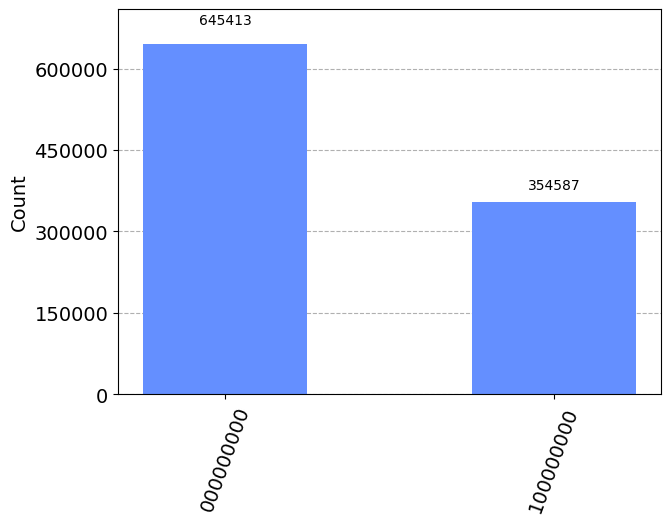

In [38]:
# 1q, 2q and measurement error.
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

noise_model = NoiseModel()

# prob changed!
prob_1 = 0.00003  # 1-qubit gate
prob_2 = 0.0015  # 2-qubit gate

error_1_dep = noise.depolarizing_error(prob_1, 1)
error_2_dep = noise.depolarizing_error(prob_2, 2)

error_1_amp  = noise.amplitude_damping_error(prob_1, 1)
error_2_amp_tmp = noise.amplitude_damping_error(prob_2, 1)
error_2_amp = error_2_amp_tmp.expand(error_2_amp_tmp)

error_1_phase = noise.phase_damping_error(prob_1, 1)
error_2_phase_tmp = noise.phase_damping_error(prob_2, 1)
error_2_phase = error_2_phase_tmp.expand(error_2_phase_tmp)

noise_model.add_all_qubit_quantum_error(error_1_dep, ['u3'])
noise_model.add_all_qubit_quantum_error(error_2_dep, ['cx'])
noise_model.add_all_qubit_quantum_error(error_1_amp, ['u3'])
noise_model.add_all_qubit_quantum_error(error_2_amp, ['cx'])
noise_model.add_all_qubit_quantum_error(error_1_phase, ['u3'])
noise_model.add_all_qubit_quantum_error(error_2_phase, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
result = execute(qc_s_offdiagonal, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model, shots=1e6).result()
counts = result.get_counts()

plot_histogram(counts)

In [4]:
# qc_s_offdiagonal.draw(output='mpl')
# qc_s_offdiagonal.count_ops()
# qc_s_offdiagonal.count_ops()

# scaling function changed!!!

In [39]:
# noise scaling changed !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
noise_scaling_function = partial(
    zne.scaling.fold_gates_at_random,
    fidelities = {"single": 1 - prob_1, 'double': 1- prob_2}
)
backend = Aer.get_backend('qasm_simulator')

def tell_signal(measure_str):
    if measure_str.count('0') % 2 == 0:
        return 'minus'
    else:
        return 'plus'

# tell the expectation value
def tell_exp(result):
    tem_dic_keys = list(result.get_counts().keys())
    tem_dic_values = list(result.get_counts().values())
    tem_exp = 0
    l = len(tem_dic_keys)
    for i in range(l):
        if tell_signal(tem_dic_keys[i]) is 'minus':
            tem_exp += -tem_dic_values[i]
        elif tell_signal(tem_dic_keys[i]) is 'plus':
            tem_exp += tem_dic_values[i]
    return tem_exp

from scipy.linalg import eigh
def eigensolver(s, hoff, hdiag):
    S = np.array([[1, s.real],[s.real,1]])
    H = np.array([[hdiag.real, hoff.real],[hoff.real, hdiag.real]])
    eigvals = eigh(H, S, eigvals_only=True, subset_by_index=[0, 1])
    return eigvals

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\17102\AppData\Local\Temp\ipykernel_33256\1008108396.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if tell_signal(tem_dic_keys[i]) is 'minus':
C:\Users\17102\AppData\Local\Temp\ipykernel_33256\1008108396.py:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif tell_signal(tem_dic_keys[i]) is 'plus':


In [40]:
# 2q gate infidelity to the offdiagonal element of the S overlap matrix
def get_s(circuit, n, num_to_average, shots, fit, plot: False):
    
    def ibmq_executor(circuit, shots = shots) -> float:
        """Returns the expectation value to be mitigated.

        Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
        # Simulate the circuit with noise
        result = execute(
            experiments=circuit,
            backend=backend,
            optimization_level=0,# Important to preserve folded gates.
            noise_model=noise_model,
            shots=shots,
        ).result()
        tem_exp = tell_exp(result)
        return tem_exp/shots
    # s offdiagonal element 
    overlap_unmitigated_list = []
    overlap_mitigated_list = []
    scaled_noise_expectation_list = []
    for _ in range(n):
        overlap_unmitigated_list.append(ibmq_executor(circuit))
        overlap_mitigated_list.append(zne.execute_with_zne(circuit, ibmq_executor, num_to_average=num_to_average, factory=fit, scale_noise = noise_scaling_function))
        scaled_noise_expectation_list.append(fit.get_expectation_values())
    if plot == True:
        fit.plot_fit()
    
    return overlap_unmitigated_list, overlap_mitigated_list

In [41]:
def get_h_diag(circuit_list, n, shots, num_to_average, fit):

    def ibmq_executor(circuit, shots= shots) -> float:
        """Returns the expectation value to be mitigated.

        Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
        # Simulate the circuit with noise
        result = execute(
            experiments=circuit,
            backend=backend,
            optimization_level=0,# Important to preserve folded gates.
            noise_model=noise_model,
            shots=shots,
        ).result()
        tem_exp = tell_exp(result)
        return tem_exp/shots

    # H diagonal
    final_unmitigated_list = []
    final_mitigated_list = []
    l =len(circuit_list)
    for a in range(n):
        pauli_unmitigated_list =[]
        pauli_mitigated_list = []
        for i in range(l):
            unmitigated = ibmq_executor(circuit_list[i])
            mitigated =  zne.execute_with_zne(circuit_list[i], ibmq_executor, num_to_average=num_to_average, factory = fit, scale_noise = noise_scaling_function)
            pauli_unmitigated_list.append(unmitigated)
            pauli_mitigated_list.append(mitigated)
        final_unmitigated = 0
        final_mitigated= 0
        for i in range(l):
            final_unmitigated += pauli_unmitigated_list[i]*float(h_diag_coefficient_list[i])
            final_mitigated += pauli_mitigated_list[i]*float(h_diag_coefficient_list[i])
        final_unmitigated += h_diag_coefficient_list[2]
        final_mitigated += h_diag_coefficient_list[2]
        final_unmitigated_list.append(final_unmitigated)
        final_mitigated_list.append(final_mitigated)
    return final_unmitigated_list, final_mitigated_list

In [42]:
# 2q gate infidelity to the offdiagonal element of the Hamiltonian matrix
def get_h_offdiag(circuit_list, n, shots, num_to_average, fit):

    def ibmq_executor(circuit, shots= shots) -> float:
        """Returns the expectation value to be mitigated.

        Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
        # Simulate the circuit with noise
        result = execute(
            experiments=circuit,
            backend=backend,
            optimization_level=0,# Important to preserve folded gates.
            noise_model=noise_model,
            shots=shots,
        ).result()
        tem_exp = tell_exp(result)
        return tem_exp/shots

    final_unmitigated_list = []
    final_mitigated_list = []
    l =len(circuit_list)
    for a in range(n):
        pauli_unmitigated_list =[]
        pauli_mitigated_list = []
        for i in range(l):
            unmitigated = ibmq_executor(circuit_list[i])
            mitigated =  zne.execute_with_zne(circuit_list[i], ibmq_executor, num_to_average = num_to_average, factory = fit, scale_noise = noise_scaling_function)
            pauli_unmitigated_list.append(unmitigated)
            pauli_mitigated_list.append(mitigated)
        final_unmitigated = 0
        final_mitigated= 0
        for i in range(l):
            final_unmitigated += pauli_unmitigated_list[i]*float(h_off_coefficient_list[i])
            final_mitigated += pauli_mitigated_list[i]*float(h_off_coefficient_list[i])
        final_unmitigated_list.append(final_unmitigated)
        final_mitigated_list.append(final_mitigated)
    return final_unmitigated_list, final_mitigated_list

# RUN EXP

In [46]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory

linear_fac = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
exp_fac = zne.inference.ExpFactory(scale_factors=[1, 1.5, 2, 2.5, 3, 3.5])

exp_factory = zne.inference.ExpFactory(scale_factors=[1, 1.5, 2, 2.5, 3], asymptote=0.0, avoid_log=True)

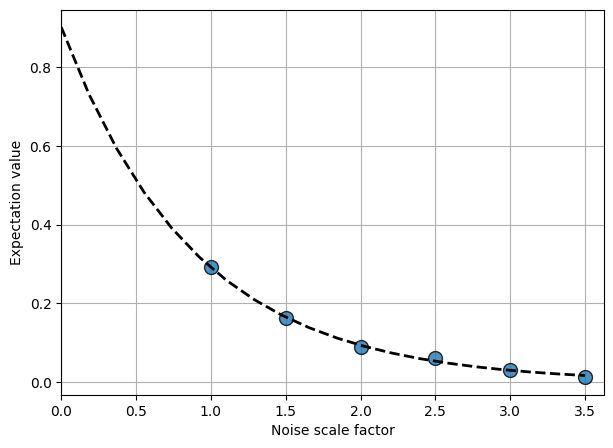

In [47]:
# total shot = num_shots * 9 circuit * 5 extrapolation = 1e4 * 45 = 450000
num_shots = 1e5
num_samples = 1
# 5min per 20
s_off, em_s_off = get_s(circuit = qc_s_offdiagonal, n = num_samples, num_to_average=1, shots = num_shots, fit= exp_fac, plot=True)
# 2 min per 20
h_diag, em_h_diag = get_h_diag(circuit_list = qc_h_diag_list, n = num_samples, num_to_average=1, shots = num_shots, fit = exp_factory)
# # 20 min per 20
h_off, em_h_off = get_h_offdiag(circuit_list = qc_h_offdiag_list, n = num_samples, num_to_average=1, shots = num_shots, fit = exp_factory)

In [48]:
print(s_off, em_s_off, h_diag, em_h_diag, h_off, em_h_off)

[0.29276] [0.9013110095092447] [-0.902576581801225] [-1.059344343797231] [-0.3079476005923283] [-0.9500639301957848]


In [ ]:
s0 = []
t1 = []
em_s0 = []
em_t1 = []
i = 0
removed_index = []
while i < num_samples:
    try:
        tmp_mitigated = eigensolver(em_s_off[i], em_h_off[i], em_h_diag[i])
        tmp_unmitigated = eigensolver(s_off[i], h_off[i], h_diag[i])
        em_s0.append(tmp_mitigated[0])
        em_t1.append(tmp_mitigated[1])
        s0.append(tmp_unmitigated[0])
        t1.append(tmp_unmitigated[1])
    except:
            removed_index.append(i)
            print("failed")
    i += 1
    print(i)

1
2
3
4
5
6
7
failed
8
failed
9
failed
10
11
12
failed
13
14
15
16
failed
17
18
19
20
21
22
23
24
25
26
failed
27
28
29
30
31
32
33
failed
34
35
36
37
failed
38
39
failed
40
41
failed
42
failed
43
44
45
failed
46
47
48
49
failed
50


In [ ]:
# Assuming the datasets are lists or similar indexable structures
removed_index = [7, 8, 9, 12, 16, 26, 33, 37, 39, 41, 42, 45, 49]

s_off = [val for idx, val in enumerate(s_off) if idx not in removed_index]
h_off = [val for idx, val in enumerate(h_off) if idx not in removed_index]
h_diag = [val for idx, val in enumerate(h_diag) if idx not in removed_index]
em_s_off = [val for idx, val in enumerate(em_s_off) if idx not in removed_index]
em_h_off = [val for idx, val in enumerate(em_h_off) if idx not in removed_index]
em_h_diag = [val for idx, val in enumerate(em_h_diag) if idx not in removed_index]

In [ ]:
hadamard_unmitigated = pd.DataFrame({'s_off': s_off, 'h_off': h_off, 'h_diag': h_diag, 's0': s0, 't1': t1})
hadamard_mitigated = pd.DataFrame({'em_s_off': em_s_off, 'em_h_off': em_h_off, 'em_h_diag': em_h_diag, 'em_s0': em_s0, 'em_t1': em_t1})

In [ ]:
# save data to the haddamard_data folder
hadamard_unmitigated.to_csv('data/hadamard_unmitigated.csv')
hadamard_mitigated.to_csv('data/hadamard_mitigated.csv')